In [1]:
from neuron import h, gui
import bokeh as bk
import bokeh.plotting as bkp
import matplotlib.pyplot as plt
import numpy as np
from bokeh.palettes import Dark2_5 as palette
import itertools 

%matplotlib inline
bkp.output_notebook()

Loading BokehJS ...

In [2]:
# approximate a spherical cell

Rm = 2800
Vrest = -65.
def passive_spherical_cell(diam,cm=1,Ra=150,g_pas=1/Rm,e_pas = Vrest):
    soma = h.Section(name='soma')
    soma.L=diam
    soma.diam = diam
    soma.cm = 1  
    soma.Ra = 150

    soma.insert('pas')
    soma.g_pas, soma.e_pas = 1/Rm, Vrest
    return soma

def add_current_clamp(seg,pos,dur = 300):
    iclamp = h.IClamp(seg(pos))
    iclamp.dur= 300
    iclamp.delay = 50
    return iclamp

def add_voltage_clamp(seg,pos,dur = 300):
    vclamp = h.VClamp(seg(pos))
    vclamp.dur = 300
    vclamp.delay(50)
    return vclamp

def run_current_clamp(soma,iclamp,i0=-.05,dI=.01,numSteps=10):
    ilist = []
    for i in range(numSteps):
        iclamp.amp = i0 + dI*i
        ilist.append(iclamp.amp)
        t_vec = h.Vector()
        v_vec = h.Vector()

        t_vec.record(h._ref_t)
        v_vec.record(soma(.5)._ref_v)

        h.tstop=500
        h.run()
        v = v_vec.as_numpy()
        if i == 0:
            V = np.zeros([numSteps, v.size])
        V[i,:]=v
        
    return t_vec.as_numpy(),V,ilist


In [3]:

# Create a cell 
soma = passive_spherical_cell(10)
# add current clamp with different strengths
iclamp = add_current_clamp(soma,.5)
# run simulations
t,V,I = run_current_clamp(soma,iclamp)

f= bkp.figure()
colors = itertools.cycle(palette)  
#for m, color in itertools.izip(xrange(10), colors):
for j, color in zip(np.arange(V.shape[0]),colors):
    f.line(t[1000::5],V[j,1000::5].T,color=color)
    
bkp.show(f)


In [89]:
# define branched cable class
class branched_cable(object):
    def __init__(self,):
        self.segments = {}
        self.stims = {}
        self.record_vecs = {}
           
    def make_cable(self,L,diam,segname='cable',cm = 1, Ra = 150,Rm = 2800, Vrest = -65.):
        cable = h.Section(name=segname,cell=self)
        cable.L = L
        cable.diam 
        cable.L=diam
        cable.diam = diam
        cable.cm = cm  
        cable.Ra = Ra
        
        cable.nseg = 10*(int((L/(0.1*h.lambda_f(100))+.999)/2.)*2 + 1)

        cable.insert('pas')
        cable.g_pas = 1/Rm
        cable.e_pas = Vrest
        self.segments[segname] = cable
        #return cable
        
    def add_branch(self,seg,pos,L,diam,segname='branch',cm = 1, Ra = 150,Rm = 2800, Vrest = -65.):
        self.make_cable(L,diam,segname=segname,cm = cm, Ra = Ra,Rm = Rm, Vrest = Vrest)
        self.segments[segname].connect(self.segments[seg](pos))
        #self.segments[segname]
                  
    def add_IClamp(self,seg,pos,amp,dur,delay = 50,stimname = 'iclamp'):
        iclamp = h.IClamp(self.segments[seg](pos))
        iclamp.amp = amp
        iclamp.dur= dur
        iclamp.delay = delay
        self.stims[stimname]=iclamp
        
    def recording_vecs(self,locations):
        # locations is list of lists with segname, location, variable
        currKeys = self.record_vecs.keys()
        if 'time' not in currKeys:
            t_vec = h.Vector()
            t_vec.record(h._ref_t)
            self.record_vecs['time']= t_vec
        
        for v in locations:
            try:
                keyname = "%s:%.2f:%s" % (v[0],v[1],v[2])
            except:
                raise("invalid specification of recording locations")
                
            
            if keyname in currKeys:
                print(keyname+"is a already a recording vec")
                
            else:
                self.record_vecs[keyname] = h.Vector()
                eval("self.record_vecs[keyname].record(self.segments[v[0]](v[1])._ref_" + v[2]+")")       

In [102]:
# make branched cable, insert stimulus on branch

cell = branched_cable()
cell.make_cable(1200,100,Ra=180)
cell.add_branch('cable',.5,50,5)
cell.add_IClamp('branch',.5,1,50)
cell.recording_vecs([['cable',.1,'v'],['cable',.5,'v'],['branch',.5,'v']])
# record along entire length of cable

In [103]:
# run simulation
h.tstop = 500
h.run()

0.0

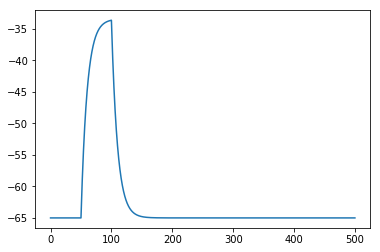

In [104]:
# plot one of the locations to make sure everything worked
plt.plot(cell.record_vecs['time'].as_numpy(),cell.record_vecs['cable:0.10:v'].as_numpy())

In [105]:
f= bkp.figure()
colors = itertools.cycle(palette)  

keys = list(cell.record_vecs.keys())
print(keys)
keys.remove('time')
for key, color in zip(keys,colors):
    print(key)
    f.line(cell.record_vecs['time'].as_numpy(),cell.record_vecs[key].as_numpy(),color=color,legend=key)
    f.legend.location="top_right"
    
bkp.show(f)

['time', 'cable:0.10:v', 'cable:0.50:v', 'branch:0.50:v']
cable:0.10:v
cable:0.50:v
branch:0.50:v
